In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: prajwalhiremath
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:00<00:00, 2.44GB/s]


In [16]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device available:", device)

device available: cpu


### Loading and preprocessing

In [17]:
image_path = []
labels = []

for i in os.listdir("/content/animal-faces/afhq"):
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"):
    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}")
      labels.append(label)

data_df = pd.DataFrame(zip(image_path, labels), columns=["image_path", "labels"])
data_df.head()

,image_path,labels
0,/content/animal-faces/afhq/train/cat/pixabay_c...,cat
1,/content/animal-faces/afhq/train/cat/pixabay_c...,cat
2,/content/animal-faces/afhq/train/cat/flickr_ca...,cat
3,/content/animal-faces/afhq/train/cat/pixabay_c...,cat
4,/content/animal-faces/afhq/train/cat/pixabay_c...,cat


In [18]:
train = data_df.sample(frac=0.7, random_state=7)
test = data_df.drop(train.index)

val = test.sample(frac=0.5, random_state=7)

test = test.drop(val.index)

print(f"Train shape : {train.shape}, Val shape : {val.shape}, Test shape : {test.shape} ")


Train shape : (11291, 2), Val shape : (2420, 2), Test shape : (2419, 2) 


In [19]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df["labels"])

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [20]:
class CustomImageDataset(Dataset):
  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)
  def __len__(self):
    return self.dataframe.shape[0]
  def __getitem__(self, indx):
    img_path = self.dataframe.iloc[indx, 0]
    label = self.labels[indx]

    image = Image.open(img_path).convert('RGB')

    if self.transform:
      image = self.transform(image).to(device)
    return image, label

In [21]:
train_dataset = CustomImageDataset(dataframe=train, transform=transform)
val_dataset = CustomImageDataset(dataframe=val, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

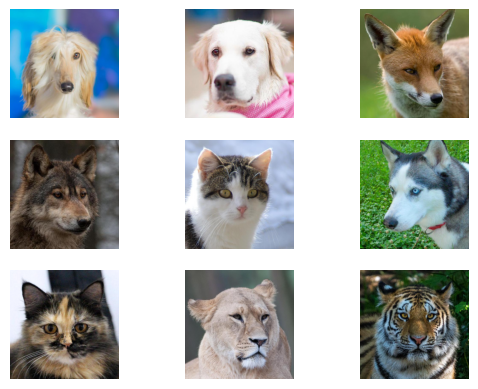

In [22]:
n_rows, n_cols = 3, 3

f, axarr = plt.subplots(nrows=n_rows, ncols=n_cols)

for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(data_df.sample(n=1)["image_path"].iloc[0]).convert('RGB')
    axarr[row, col].imshow(image)
    axarr[row, col].axis('off')
plt.show()

In [23]:
LR  = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [24]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


## Model

In [25]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3,32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

    self.pooling = nn.MaxPool2d(2,2)
    self.relu = nn.ReLU()

    self.flatten = nn.Flatten()

    self.linear = nn.Linear((128*16*16), 128)

    self.output = nn.Linear(128, len(data_df['labels'].unique()))

  def forward(self, x):
    x = self.conv1(x) # starts with 128*128*3 to 128*128*32
    x = self.pooling(x) # outputs : 32*64*64
    x = self.relu(x) # [32*64*64] relu doesn't changes anything, it only changes the values inside the matrix

    x = self.conv2(x) # 32*64*64 to 64*64*64
    x = self.pooling(x) # 64*64*64 to 64*32*32
    x = self.relu(x) # [64*32*32]

    x = self.conv3(x) # 64*32*32 to 128*32*32
    x = self.pooling(x) # 128*32*32 to 128*16*16
    x = self.relu(x) # [128*16*16]

    x = self.flatten(x)
    x = self.linear(x)
    x = self.output(x)
    return x




In [26]:
model = Net().to(device)

In [27]:
from torchsummary import summary

summary(model, input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)

In [29]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_val = 0
  total_loss_val = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad() # we can put this at end or begining of the model

    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()

    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1)==labels).sum().item()

    total_acc_train += train_acc

    optimizer.step()

  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis=1)==labels).sum().item()
      total_acc_val += val_acc
  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round((total_acc_train/train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round((total_acc_val/val_dataset.__len__())*100, 4))
  print(f"""
  Epoch {epoch + 1}/{EPOCHS}, Training Loss : {round(total_loss_train/1000, 4)} Train Accuracy : {round((total_acc_train/train_dataset.__len__())*100, 4)}
        Validation loss : {round(total_loss_val/1000, 4)}, Validation Accuracy : {round((total_acc_val/val_dataset.__len__())*100, 4)}
  """)


  Epoch 1/10, Training Loss : 0.3232 Train Accuracy : 80.9229
        Validation loss : 0.0483, Validation Accuracy : 87.314
  

  Epoch 2/10, Training Loss : 0.1325 Train Accuracy : 93.145
        Validation loss : 0.0228, Validation Accuracy : 95.0826
  

  Epoch 3/10, Training Loss : 0.0842 Train Accuracy : 95.864
        Validation loss : 0.019, Validation Accuracy : 95.4132
  

  Epoch 4/10, Training Loss : 0.0625 Train Accuracy : 96.8736
        Validation loss : 0.0178, Validation Accuracy : 95.7438
  

  Epoch 5/10, Training Loss : 0.042 Train Accuracy : 97.963
        Validation loss : 0.0173, Validation Accuracy : 96.1157
  

  Epoch 6/10, Training Loss : 0.0309 Train Accuracy : 98.4589
        Validation loss : 0.0152, Validation Accuracy : 96.6529
  

  Epoch 7/10, Training Loss : 0.0224 Train Accuracy : 99.0258
        Validation loss : 0.0188, Validation Accuracy : 95.8678
  

  Epoch 8/10, Training Loss : 0.0156 Train Accuracy : 99.256
        Validation loss : 0.0174, 

In [38]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    predictions = model(inputs)
    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc

    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

print(f"""
Testing Accuracy : {round((total_acc_test/test_dataset.__len__())*100, 4)} and Loss : {round(total_loss_test/1000, 4)}
""")



Testing Accuracy : 95.9487 and Loss : 0.0253



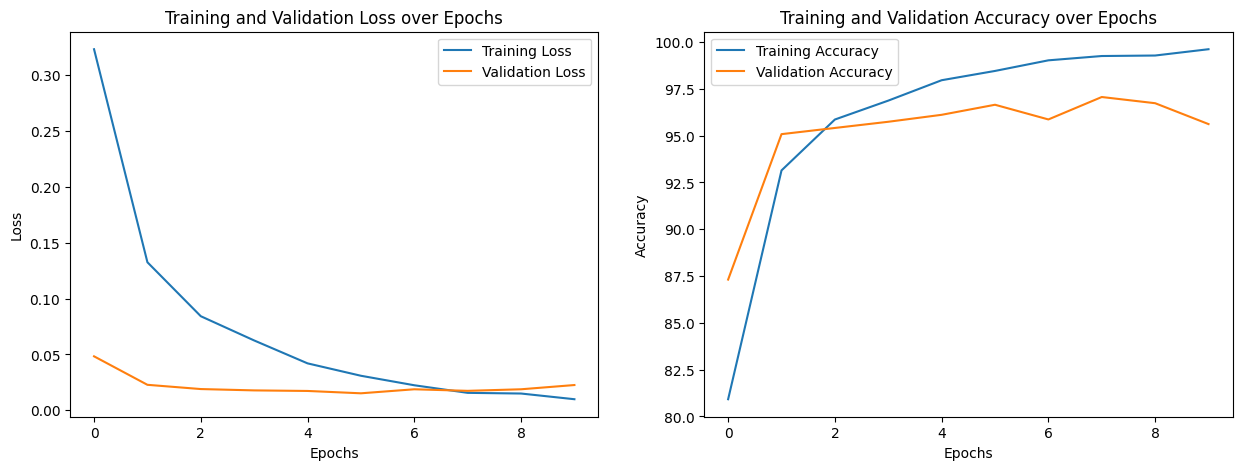

In [31]:
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axis[0].plot(total_loss_train_plot, label='Training Loss')
axis[0].plot(total_loss_validation_plot, label="Validation Loss")
axis[0].set_title("Training and Validation Loss over Epochs")
axis[0].set_xlabel('Epochs')
axis[0].set_ylabel('Loss')
axis[0].legend()

axis[1].plot(total_acc_train_plot, label='Training Accuracy')
axis[1].plot(total_acc_validation_plot, label="Validation Accuracy")
axis[1].set_title("Training and Validation Accuracy over Epochs")
axis[1].set_xlabel('Epochs')
axis[1].set_ylabel('Accuracy')
axis[1].legend()

In [36]:
def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)

  output = model(image.unsqueeze(0)) # unsqueeze will add the batch number as '1'. If not we get an error, since we always added the batch_size as a parameter for train, val, and test
  output = torch.argmax(output, axis=1).item()
  return label_encoder.inverse_transform([output])

In [37]:
predict_image("/content/test.jpg")

array(['dog'], dtype=object)